# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


In [1]:
import os
import xarray as xr
import numpy as np
from scipy.special import erfc, erf


import matplotlib.pyplot as plt
from cycler import cycler

import viggiano_2020 as vig
import plot as fplt
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

from GDP_lib import root_dir


---

# N-layers Embedded OU processes: Viggiano et al. 2020 

We generate timeseries corresponding to their equations (2.14-2.18).


## Generate

In [6]:
# decorrelation timescales
T = [5,10,20,40]
t = (1000, 1 / 24) # timeline: 1000 days with hourly sampling
N = 10 # number of random draws
u_std = 2

In [7]:
tau_eta = 1/48 # short timescale
n_layers = 5 # number of layers
u_std = 1 
da = u_std * ts.spectral_viggiano(t, T, tau_eta, n_layers, draws=N).compute()
print(' ok0')
# derive position and acceleration
ds = da.rename("u").assign_attrs(units="m/s").to_dataset().persist()
ds["time"] = ds["time"].assign_attrs(units="days")
ds["x"] = (ds["u"].cumulative_integrate("time")*86400).assign_attrs(units="m")
ds["a"] = (ds["u"].differentiate("time")/86400).assign_attrs(units=r"$m/s^2$")  # rescale in m/s
ds = ds.chunk({'T':-1, 'time' :24000, 'draw':-1}).persist()
print(' ok1')


# compute autocorrelations
xx = sigp.correlate(ds.x, ds.x).rename("xx").persist().assign_attrs(long_name=r'$C_x(\tau)$', units="")
print(' ok2')
uu = sigp.correlate(ds.u, ds.u).rename("uu").persist().assign_attrs(long_name=r'$C_u(\tau)$', units="")
print(' ok3')
aa = sigp.correlate(ds.a, ds.a).rename("aa").persist().assign_attrs(long_name=r'$C_a(\tau)$', units="")
dsc = xr.merge([xx, uu, aa])
print(' ok4')


# compute spectra
Ex, omega = sigp.spectrum_welch(ds.x, T=100)
print(' ok5')
Eu, omega = sigp.spectrum_welch(ds.u, T=100)
print(' ok6')
Ea, omega = sigp.spectrum_welch(ds.a, T=100)
dsE = xr.merge([Ex.assign_attrs(long_name = 'Power density spectra of x', units=r"$m^2/cpd$"), 
                Eu.assign_attrs(long_name = 'Power density spectra of u',units=r"$m^2/s^2/cpd$"),
                Ea.assign_attrs(long_name = 'Power density spectra of a',units=r"$m^2/s^4/cpd$")])
dsE = dsE.rename({i : 'E'+i for i in list(dsE.keys())})
ds_ou = xr.merge([ds, dsc, dsE])

ds_ou.T.attrs = {'long_name' : 'Correlation time T', 'units':'days'}
ds_ou.lags.attrs = {'long_name':r'$\tau$', 'units':'days'}
ds_ou.freq_time.attrs = { 'units':'cpd'} 
ds_ou.attrs = {'description':'synthetic trajectories simulated via the embedded OU process of Viggiano et al. 2020 (equations (2.14-2.18))', 'tau_eta_days':tau_eta, 'n_layers':n_layers, "sigma_u":u_std}
ds_ou

 ok0
 ok1
 ok2
 ok3
 ok4
 ok5
 ok6


<xarray.Dataset>
Dimensions:    (T: 4, time: 24000, draw: 10, lags: 24000, freq_time: 2400)
Coordinates:
  * T          (T) int64 5 10 20 40
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
Data variables:
    u          (T, time, draw) float64 dask.array<chunksize=(4, 24000, 10), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 24000, 10), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 24000, 10), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    tau_eta_days:  0.020833333333333332
    n_layers:      5
    sigma_u:       1

In [4]:
ds48 = ds_ou #tau_eta=1/48

In [13]:
ds1 = ds_ou #tau_eta=3

## Or load

In [4]:
path = os.path.join(root_dir, "synthetic_traj_ou_taueta.zarr")
ds = xr.open_zarr(path, decode_timedelta=False)# tau_eta=1
ds

<xarray.Dataset>
Dimensions:    (T: 4, tau_eta: 4, draw: 10, freq_time: 2400, time: 24000,
                lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * tau_eta    (tau_eta) float64 0.02083 1.0 2.0 3.0
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 4, 10, 2400), meta=np.ndarray>
    Eu         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 4, 10, 2400), meta=np.ndarray>
    Ex         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 4, 10, 2400), meta=np.ndarray>
    a          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 4, 5000, 10), meta=np.ndarray>
    aa         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 4, 10, 5000), meta=np.ndarray>
    u          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 4, 5000, 10), meta=np.ndarray>
    uu         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 4, 10, 5000), meta=np.ndarray>
    x          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 4, 5000, 10), meta=np.ndarray>
    xx         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 4, 10, 5000), meta=np.ndarray>
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  [0.020833333333333332, 1, 2, 3]

________
## Verify viggiano bib :  CV pour n=1 -> OK

In [4]:
a = vig.PSDu_exp(ds.freq_time*2*np.pi,
            ds.attrs["sigma_u"],
            ds.T)
b = vig.PSDu_ou(ds.freq_time*2*np.pi,
            ds.attrs["sigma_u"],
            ds.T, 
            ds.attrs['tau_eta_days'], n=1)


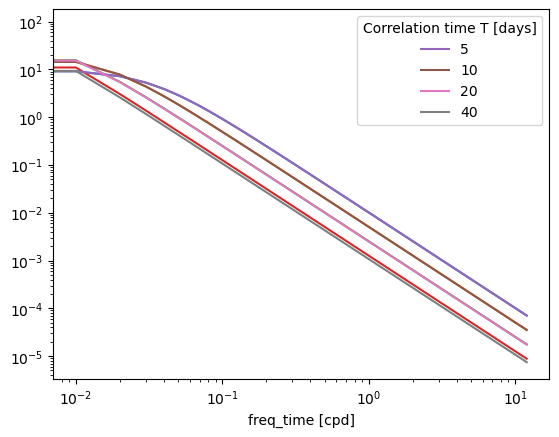

In [6]:
a.plot(hue='T')
b.plot(hue='T')
plt.xscale('log')
plt.yscale('log')

________________
## Theoritical behaviour of PSD, autocorrrelation

In [3]:
def add_theoritical_func(ds):
    ds['PSDu'] = vig.PSDu_ou_ds(ds)
    ds['PSDa'] = vig.PSDa_ou_ds(ds)
    ds['PSDu_exp'] = vig.PSDu_exp_ds(ds)
    ds['PSDa_exp'] = vig.PSDa_exp_ds(ds)
    ds['coru'] = vig.Coru_ou_inf_ds(ds)
    ds['cora'] = vig.Cora_ou_inf_ds(ds)
add_theoritical_func(ds)
#add_theoritical_func(ds48)
#add_theoritical_func(ds1)
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 100, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/15)
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    ...         ...
    PSDu       (T, freq_time) float64 5.133e-09 5.173e-09 ... 5.397e-10
    PSDa       (T, freq_time) float64 3.909e-15 3.933e-15 ... 4.103e-16
    PSDu_exp   (T, freq_time) float64 7.036e-05 7.048e-05 ... 8.825e-06 8.81e-06
    PSDa_exp   (T, freq_time) float64 5.358e-11 5.358e-11 ... 6.698e-12
    coru       (lags, T) float64 1.0 1.0 1.0 ... 3.753e-44 1.937e-22 1.392e-11
    cora       (T, lags) float64 2.694 2.089 0.9655 ... -2.248e+07 -2.25e+07
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  0.041666666666666664

Text(0.5, 1.0, '')

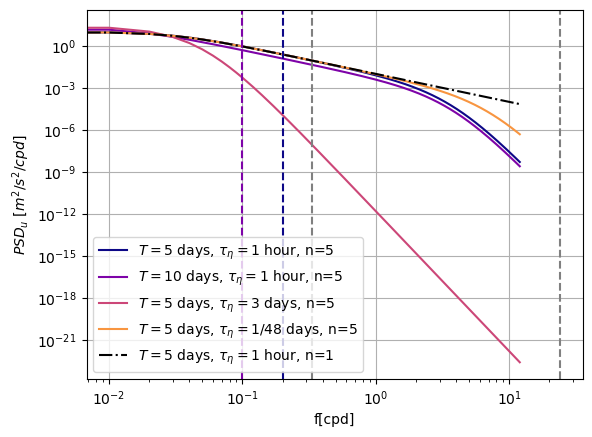

In [24]:
ds.PSDu.sel(T=5).plot(color = colors[0],label=r'$T=5$ days, $\tau_{\eta}=1$ hour, n=5')
ds.PSDu.sel(T=10).plot(color = colors[1],label=r'$T=10$ days, $\tau_{\eta}=1$ hour, n=5')
ds1.PSDu.sel(T=5).plot(color = colors[2],label=r'$T=5$ days, $\tau_{\eta}=3$ days, n=5')
ds48.PSDu.sel(T=5).plot(color = colors[3],label=r'$T=5$ days, $\tau_{\eta}=1/48$ days, n=5')
ds.PSDu_exp.sel(T=5).plot(color = 'k', ls='-.', label=r'$T=5$ days, $\tau_{\eta}=1$ hour, n=1')

plt.axvline(1/5, ls='--', color = colors[0])
plt.axvline(1/10, ls='--', color = colors[1])
plt.axvline(24, ls='--', color = 'grey')
plt.axvline(1/3, ls='--', color = 'grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f[cpd]')
plt.ylabel(r'$PSD_u$ $[m^2/s^2/cpd]$')
plt.grid()
plt.legend()
plt.title('')

Text(0.5, 1.0, '')

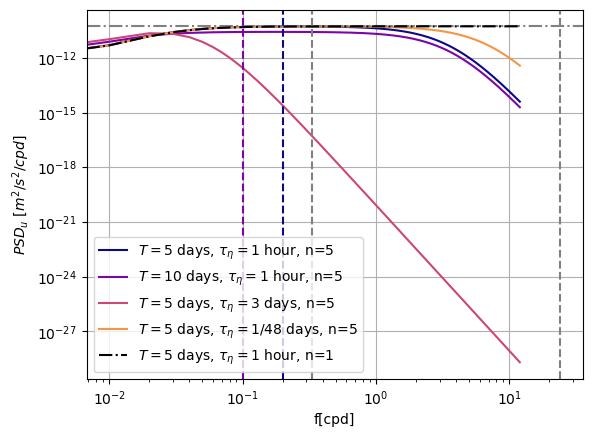

In [25]:
ds.PSDa.sel(T=5).plot(color = colors[0],label=r'$T=5$ days, $\tau_{\eta}=1$ hour, n=5')
ds.PSDa.sel(T=10).plot(color = colors[1],label=r'$T=10$ days, $\tau_{\eta}=1$ hour, n=5')
ds1.PSDa.sel(T=5).plot(color = colors[2],label=r'$T=5$ days, $\tau_{\eta}=3$ days, n=5')
ds48.PSDa.sel(T=5).plot(color = colors[3],label=r'$T=5$ days, $\tau_{\eta}=1/48$ days, n=5')
plt.axhline(2/5/(86400**2), ls='-.', color='grey')
ds.PSDa_exp.sel(T=5).plot(color = 'k', ls='-.', label=r'$T=5$ days, $\tau_{\eta}=1$ hour, n=1')

plt.axvline(1/5, ls='--', color = colors[0])
plt.axvline(1/10, ls='--', color = colors[1])
plt.axvline(24, ls='--', color = 'grey')
plt.axvline(1/3, ls='--', color = 'grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f[cpd]')
plt.ylabel(r'$PSD_u$ $[m^2/s^2/cpd]$')
plt.grid()
plt.legend()
plt.title('')

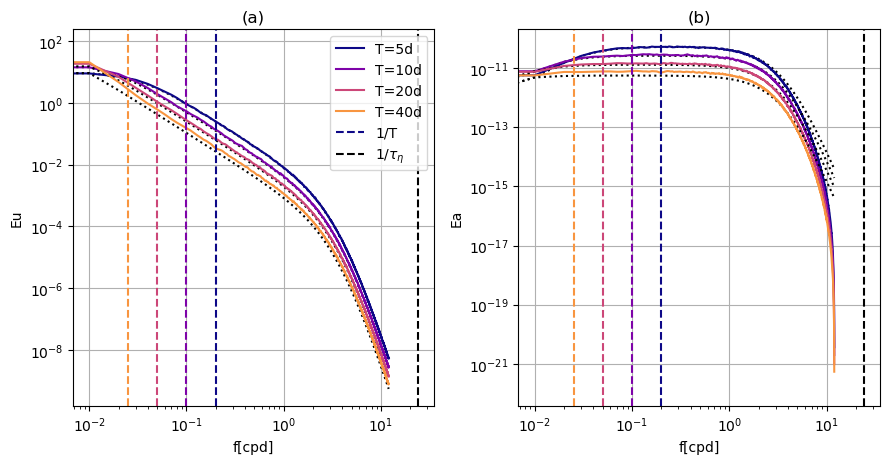

In [6]:
plot_psd(ds);

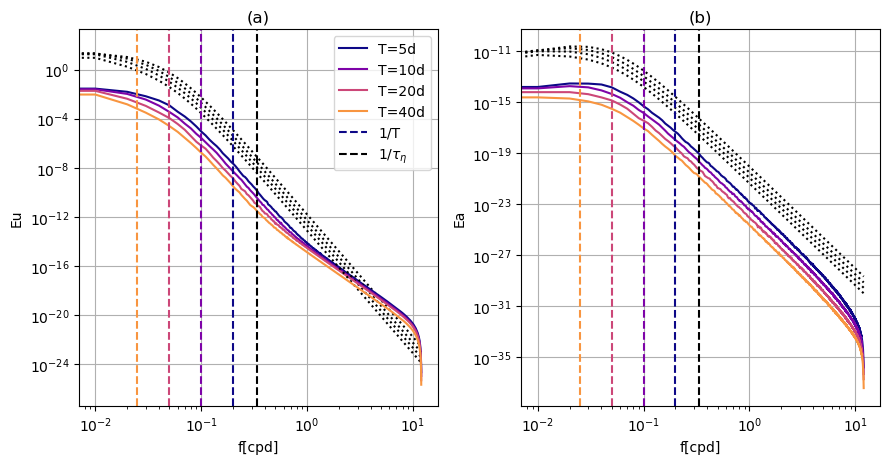

In [27]:
plot_psd(ds1);

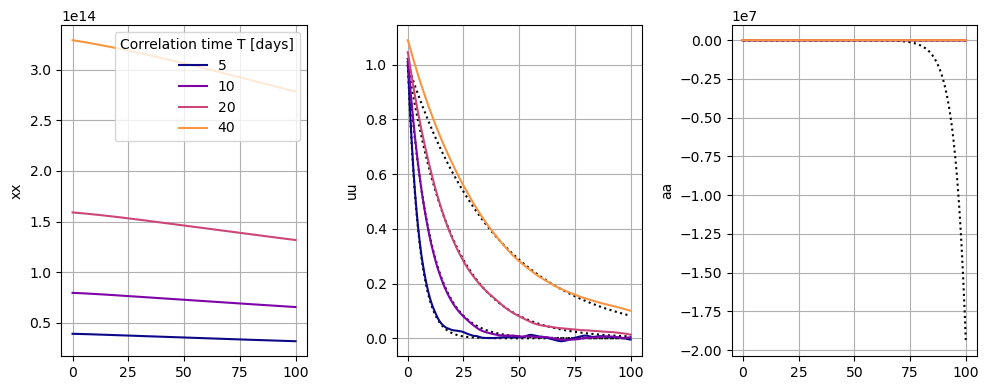

In [51]:
plot_autocorrelations(ds.mean('draw'), tau_max=100);

## Verify Parseval

In [45]:
ds.Eu.integrate("freq_time").compute()

<xarray.DataArray 'Eu' (T: 4, draw: 100)>
array([[0.99547599, 0.9999583 , 0.93910623, 1.03366981, 1.03914287,
        1.02227092, 0.99420903, 0.95248259, 1.00080324, 0.96983205,
        0.98604684, 0.97879599, 1.01852593, 1.02597618, 1.02523099,
        1.01626058, 1.02165224, 0.98727834, 0.99946918, 0.94185794,
        1.05757012, 1.02463229, 1.04145672, 1.0113074 , 1.10811253,
        1.0221086 , 1.01497043, 1.05823282, 1.03506886, 1.0247998 ,
        1.01571396, 0.97559738, 1.03195183, 1.08442576, 0.97442684,
        1.04593809, 0.96880447, 0.97483104, 1.01702504, 1.02818205,
        1.00599975, 1.00738272, 1.09197848, 0.97242091, 0.98891556,
        0.99390078, 1.06680974, 1.02708514, 0.99647807, 1.03173912,
        1.04415444, 1.01623269, 1.08088189, 1.04936755, 0.94812209,
        0.99427912, 1.00001787, 1.01713804, 0.94477769, 0.96558491,
        1.03045965, 1.03356918, 1.06367934, 0.97612412, 1.01224889,
        1.06224232, 1.0033293 , 0.97182191, 0.97955447, 1.09038501,
        1.02792528, 1.03468892, 1.0083662 , 0.9724345 , 1.0327019 ,
        1.02541693, 0.97649324, 1.02176435, 1.0372803 , 0.9905362 ,
        1.01006318, 1.02484201, 1.03094863, 1.01416276, 1.00625344,
        0.96424915, 0.95649871, 1.03171014, 0.98772967, 1.00988402,
        0.95305432, 1.00043546, 1.04367463, 0.9967243 , 1.02608806,
        0.99664052, 0.95032636, 1.0419623 , 1.06292431, 1.02737489],
...
       [0.98428188, 1.22019262, 1.00981434, 1.03768903, 1.23082803,
        0.94745475, 0.95233765, 1.0698924 , 1.06134376, 1.02536601,
        1.08893613, 1.03952948, 1.11366036, 1.05144192, 1.03660292,
        1.04260381, 1.22899786, 1.03144171, 1.0185577 , 1.14099522,
        0.91635805, 1.03668341, 0.99017788, 1.15252379, 0.96785971,
        1.13672582, 0.86422859, 1.33899577, 1.02949638, 1.47615873,
        1.07811399, 0.96488795, 1.02861363, 0.94757231, 0.96038321,
        1.16470594, 1.08737077, 0.92613281, 1.04910525, 1.1499821 ,
        1.12861366, 1.0654189 , 0.9978891 , 1.00901247, 0.96589442,
        1.01612538, 1.05863173, 1.08736694, 1.08995744, 1.24565552,
        1.15657174, 1.01456597, 1.54399797, 1.25185791, 1.09033305,
        0.82598832, 1.11355275, 1.09625055, 1.38261883, 1.08047524,
        1.30273365, 0.92912015, 0.9634923 , 1.10878471, 1.07820008,
        0.86337102, 1.45788298, 1.24320317, 1.00609858, 1.05701223,
        1.1098426 , 1.09381914, 1.0442101 , 0.94843507, 1.0388719 ,
        1.31305063, 0.96099349, 1.02850223, 1.05691344, 1.41771652,
        1.0020184 , 1.10413221, 1.08830836, 1.06185138, 1.08082385,
        1.14567887, 1.13160809, 1.0186335 , 1.05231714, 1.004041  ,
        1.00922715, 1.22054541, 1.4242046 , 1.09855344, 1.12654132,
        1.05613841, 1.03981786, 0.99412453, 1.18105386, 1.21965996]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99

In [46]:
ds.PSDu.integrate("freq_time").compute()

<xarray.DataArray 'PSDu' (T: 4)>
array([1., 1., 1., 1.])
Coordinates:
  * T        (T) int64 5 10 20 40